In [ ]:
%matplotlib inline
import numpy as np
import random
import copy
from numpy.random import choice
import matplotlib.pyplot as plt
import math
from matplotlib.colors import ListedColormap
import sys
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
def get_weightComponent(value):
  result = (value -math.floor(value)) * 10
  return math.floor(result)

def weighting(matrix, i, j, m, n):
    total = 0.0

    if i==0 and j+2 < n and i+2 <m:
        total = (get_weightComponent(matrix[i, j+2]) + get_weightComponent(matrix[i+1, j+2]) + get_weightComponent(matrix[i+2, j+2]) + get_weightComponent(matrix[i+2, j+1]) + get_weightComponent(matrix[i+2, j])) /5
    elif j == n-1 and i+2 < m:
        total = (get_weightComponent(matrix[i+2, j]) + get_weightComponent(matrix[i+2, j-1]) + get_weightComponent(matrix[i+2, j-2]) + get_weightComponent(matrix[i+1, j-2]) + get_weightComponent(matrix[i, j-2]))/5
    elif i != 0 and j != n-1 and i+2 < m and j+2 < n:
        total = (get_weightComponent(matrix[i, j+2]) + get_weightComponent(matrix[i+1, j+2]) + get_weightComponent(matrix[i+2, j+2]) + get_weightComponent(matrix[i+2, j+1]) + get_weightComponent(matrix[i+2, j]) + get_weightComponent(matrix[i+2, j-1]) + get_weightComponent(matrix[i+2, j-2]) + get_weightComponent(matrix[i+1, j-2]) + get_weightComponent(matrix[i, j-2]))/9

    total = total * 10


    prob = 0.0

    if total < 4:
        prob = 0.8
    elif total >= 4 and total <=6:
        prob = 0.55
    elif total > 6:
        prob = 0.3

    return prob

In [ ]:
def in_boundary(pos, ep, layers):
  # print('--exit: ', ep)
  # print('--pos: ', pos)
  i = ep[0]
  j = ep[1]

  inBoundary = False

  if pos == ep:
    inBoundary = True

  for x in range(1, layers+1):
    boundaries = [[i,j-x], [i-x, j-x], [i-x,j], [i-x, j+x], [i, j+x], [i+x, j+x], [i+x, j], [i+1, j-x]]
    if pos in boundaries:
      inBoundary = True
      break

  return inBoundary

In [ ]:
def create_divisions(total_div, total_rows):
  div = math.floor(total_rows/total_div)
  results = []

  start = 0

  for i in range(total_div):
    start +=div
    results.append(start)

  return results

In [ ]:
def selected_path(vehicles, paths_title):
    paths_arr = {}
    num_paths = len(paths_title)

    # Calculate base count and remainder
    base_count = vehicles // num_paths
    remainder = vehicles % num_paths

    vehicle_id = 1
    for i, path in enumerate(paths_title):
        # Distribute base count + 1 for the first `remainder` paths
        count = base_count + (1 if i < remainder else 0)
        for _ in range(count):
            paths_arr[vehicle_id] = path
            vehicle_id += 1

    return paths_arr

import numpy as np
import random
from collections import defaultdict

def selected_path(matrix, vel_paths, distance_threshold=1.0, mode='random'):
    """
    Assigns each vehicle in the matrix to a path based on proximity to path starts.
    If multiple paths are equally close, uses random or load-balanced tie-breaking.

    Args:
        matrix: 2D numpy array with vehicle IDs as non-zero and non-minus-one entries.
        vel_paths: dict of path name -> list of (row, col) coordinates.
        distance_threshold: optional float, to consider multiple "close enough" paths.
        mode: 'random' or 'balanced' to resolve ties among equally close paths.

    Returns:
        Dictionary mapping vehicle ID -> selected path name.
    """
    paths_arr = {}
    path_usage = defaultdict(int)

    rows, cols = matrix.shape

    for r in range(rows):
        for c in range(cols):
            val = matrix[r, c]
            if val != 0 and val != -1:
                pos = np.array([r, c])

                # Compute distances to path starts
                distances = []
                for title, path in vel_paths.items():
                    start_point = np.array(path[0])
                    dist = np.linalg.norm(pos - start_point)
                    distances.append((dist, title))

                # Find minimum distance
                min_dist = min(distances, key=lambda x: x[0])[0]

                # Collect all paths within threshold of that min_dist
                close_paths = [title for dist, title in distances if abs(dist - min_dist) <= distance_threshold]

                # Pick from close_paths based on mode
                if mode == 'random':
                    selected = random.choice(close_paths)
                elif mode == 'balanced':
                    selected = min(close_paths, key=lambda t: path_usage[t])
                else:
                    raise ValueError("mode must be 'random' or 'balanced'")

                paths_arr[math.floor(val)] = selected
                path_usage[selected] += 1

    return paths_arr

import numpy as np
from collections import defaultdict

def even_distributed_path_assignment(matrix, vel_paths):
    vehicle_positions = []
    vehicle_ids = []
    path_starts = {pname: np.array(coords[0]) for pname, coords in vel_paths.items()}

    # Step 1: extract vehicle positions
    rows, cols = matrix.shape
    for r in range(rows):
        for c in range(cols):
            val = matrix[r, c]
            if val != 0 and val != -1:
                vehicle_positions.append(np.array([r, c]))
                vehicle_ids.append(math.floor(val))

    num_vehicles = len(vehicle_positions)
    num_paths = len(path_starts)

    # Step 2: compute distance matrix
    distance_records = []
    for idx, pos in enumerate(vehicle_positions):
        for path_name, start in path_starts.items():
            dist = np.linalg.norm(pos - start)
            distance_records.append((dist, vehicle_ids[idx], path_name))

    # Step 3: sort all distances and assign while respecting even distribution
    distance_records.sort()  # ascending by distance

    # Quota setup
    base_quota = num_vehicles // num_paths
    remainder = num_vehicles % num_paths
    path_limits = {p: base_quota + (1 if i < remainder else 0) for i, p in enumerate(path_starts)}

    assigned = {}
    used_paths = defaultdict(int)
    assigned_vehicles = set()

    for dist, vid, path in distance_records:
        if vid in assigned_vehicles:
            continue
        if used_paths[path] < path_limits[path]:
            assigned[vid] = path
            used_paths[path] += 1
            assigned_vehicles.add(vid)

    return assigned




In [ ]:
def direction_to_go(current_pos, waypoints, exit_point, matrix):
    i, j = current_pos
    result = [0, 0]
    min_total_dist = float('inf')

    current_vec = np.array(current_pos)
    exit_vec = np.array(exit_point)
    exit_dir = exit_vec - current_vec

    # Sort waypoints by how close they are to the exit
    sorted_wpts = sorted(waypoints, key=lambda wp: np.linalg.norm(np.array(wp) - exit_vec))

    # Pick the nearest waypoint that's in front of us (towards the exit)
    for wp in sorted_wpts:
        wp_vec = np.array(wp)
        to_wp = wp_vec - current_vec

        # Check that this waypoint is ahead, not behind (dot product > 0)
        if np.dot(to_wp, exit_dir) > 0:
            target = wp
            break
    else:
        # No forward waypoints, go directly to exit
        target = exit_point

    # 8 possible directions
    neighbors = [
        [i-1, j-1], [i-1, j], [i-1, j+1],
        [i,   j-1],           [i,   j+1],
        [i+1, j-1], [i+1, j], [i+1, j+1]
    ]

    for ni, nj in neighbors:
        if 0 <= ni < matrix.shape[0] and 0 <= nj < matrix.shape[1]:
            if matrix[ni, nj] == 0:
                dist = np.linalg.norm(np.array([ni, nj]) - np.array(target))
                if dist < min_total_dist:
                    min_total_dist = dist
                    result = [ni, nj]

    return result

In [ ]:
def direction_to_go(current_pos, waypoints, matrix, vehicle_passed_index, val):

    i, j = current_pos
    result = [0, 0]
    min_total_dist = float('inf')

    #print(vehicle_passed_index)

    passed_index = vehicle_passed_index.get(val, -1)
    target = []

    if passed_index == -1:
        target = waypoints[0]
        vehicle_passed_index[val] = 0
    else:
        if passed_index < len(waypoints) - 1:
            target = waypoints[passed_index + 1]
            vehicle_passed_index[val] = passed_index + 1
        else:
            target = waypoints[-1]

    neighbors = [
        [i-1, j-1], [i-1, j], [i-1, j+1],
        [i,   j-1],           [i,   j+1],
        [i+1, j-1], [i+1, j], [i+1, j+1]
    ]


    for ni, nj in neighbors:
        if 0 <= ni < matrix.shape[0] and 0 <= nj < matrix.shape[1]:
            if matrix[ni, nj] == 0:
                dist = np.linalg.norm(np.array([ni, nj]) - np.array(target))
                if dist < min_total_dist:
                    min_total_dist = dist
                    result = [ni, nj]

    return result

#current_pos - [2,3]
#waypoints - [[1,2], [3,4], [5,6]]
##matrix - np.array([[0, 0, 1], [0, 0, 0], [1, 0, 0]])
#vehicle_progress_map - {1: 0, 2: 1}
#vehicle_id - 1

def direction_to_gov2(current_pos, waypoints, matrix, vehicle_progress_map, vehicle_id):
    i, j = current_pos
    result = [0, 0]  # Default: stay in place
    min_dist = float('inf')

    # Get current waypoint index for this vehicle
    current_idx = vehicle_progress_map.get(vehicle_id, 0)

    # If completed all waypoints, stay put
    if current_idx >= len(waypoints):
        current_idx = len(waypoints) - 1

    target = waypoints[current_idx]

    # Check if current position is adjacent to target
    if abs(i - target[0]) <= 1 and abs(j - target[1]) <= 1:
        # Consider waypoint 'visited'
        current_idx += 1
        vehicle_progress_map[vehicle_id] = current_idx

        if current_idx < len(waypoints):
            target = waypoints[current_idx]
        else:
            current_idx = len(waypoints) - 1
            target = waypoints[current_idx]

    # Define 8-directional neighbors
    neighbors = [
        [i-1, j-1], [i-1, j], [i-1, j+1],
        [i,   j-1],           [i,   j+1],
        [i+1, j-1], [i+1, j], [i+1, j+1]
    ]

    # Pick the neighbor closest to the current target
    for ni, nj in neighbors:
        if 0 <= ni < matrix.shape[0] and 0 <= nj < matrix.shape[1]:
            if matrix[ni, nj] == 0:  # Free cell
                dist = np.linalg.norm(np.array([ni, nj]) - np.array(target))
                if dist < min_dist:
                    min_dist = dist
                    result = [ni, nj]

    return result



In [ ]:

def get_custom_region_positions(row_start, row_end, col_start, col_end, wp):
    """
    Return available positions within specified rows and columns, excluding wall positions.
    """
    positions = [
        [i, j]
        for i in range(row_start, row_end)
        for j in range(col_start, col_end)
        if [i, j] not in wp
    ]
    return positions

def create_matrix_from_custom_regions(m, n, v, wp, region_distribution):
    vehicle_dist = {}
    """
    Create a matrix of size m x n, fill vehicles based on custom region distribution, and place walls.

    Args:
        m (int): number of rows
        n (int): number of columns
        v (int): total number of vehicles
        wp (list): list of wall positions [[row, col], ...]
        region_distribution (dict): {(row_start, row_end, col_start, col_end): percent, ...}

    Returns:
        np.ndarray: matrix with vehicles and walls
    """
    matrixA = np.zeros((m, n))
    vehicle_count = 1

    for (r_start, r_end, c_start, c_end), percent in region_distribution.items():
        count = int(v * percent)
        positions = get_custom_region_positions(r_start, r_end, c_start, c_end, wp)

        if len(positions) < count:
            raise ValueError(f"Not enough positions in region ({r_start}:{r_end}, {c_start}:{c_end})")

        selected_positions = random.sample(positions, count)

        for pos in selected_positions:
            val = vehicle_count + (
                random.choices([1, 2, 3, 4], weights=[0.4, 0.4, 0.1, 0.1])[0] * 0.1
            )
            matrixA[pos[0], pos[1]] = val
            vehicle_count += 1

            vehicle_dist[val] = (r_start, r_end, c_start, c_end)

    for w in wp:
        matrixA[w[0], w[1]] = -1  # mark wall

    return matrixA, vehicle_dist

def rentry_by_regions(matrix_copy, val, i, j, chosen_region, wp=[]):
    """
    Move vehicle at (i,j) to a new location in matrix_copy based on
    specified re-entry regions and their probabilities.

    Args:
        matrix_copy: 2D numpy array representing the grid
        val: vehicle value/type
        i, j: current vehicle position to clear
        region_distribution: dict with keys as (r_start, r_end, c_start, c_end)
                             and values as probabilities (sum to 1)
        wp: list of wall positions (optional)

    Returns:
        matrix_copy: updated matrix with vehicle re-entered (or unchanged if failed)
        success: bool, True if re-entry succeeded, else False
    """

    r_start, r_end, c_start, c_end = chosen_region

    available_positions = [
        (r, c)
        for r in range(r_start, r_end)
        for c in range(c_start, c_end)
        if matrix_copy[r, c] == 0 and [r, c] not in wp
    ]

    if not available_positions:
        print(f"No available positions in region {chosen_region} for re-entry.")
        return matrix_copy

    new_r, new_c = random.choice(available_positions)

    matrix_copy[i, j] = 0
    matrix_copy[new_r, new_c] = val

    return matrix_copy


In [ ]:
def translate_matrix(matrix,
                     sel_paths, vel_paths, vehicle_dist, vehicle_travel, layers=2):
  m = matrix.shape[0]
  n = matrix.shape[1]

  matrix_copy = copy.deepcopy(matrix)
  explored_sets = []
  dist = 0


  for i in range(0,m):
    for j in range(0,n):

      val = matrix_copy[i,j]

      #print(val)
      v_weight = get_weightComponent(val)
      if (v_weight== 1 or v_weight== 2 or v_weight== 3) and [i,j] not in explored_sets:
        way_points = vel_paths[sel_paths[math.floor(val)]]

        at_boundary = in_boundary([i,j], way_points[-1],layers)

        way_togo = direction_to_gov2([i,j], way_points,matrix_copy, vehicle_travel, val)
        move_prob = weighting(matrix, i, j, m, n)

        if at_boundary == False and way_togo != [0,0]:
            if np.random.rand() < move_prob:
              matrix_copy[i,j] = 0
              matrix_copy[way_togo[0], way_togo[1]] = val
              dist += 1
              explored_sets.append(way_togo)

        else:
          #re-enter
          #print('should re-enter')
          #print(f"Vehicle {val} at position ({i}, {j}) with waypoints: {way_points}")
          matrix_copy = rentry_by_regions(matrix_copy, val, i, j, vehicle_dist[val], way_points)
          break


  return matrix_copy, dist

In [ ]:
def run(time=100, rows=100, columns=100, vehicles=50):

    time = time
    result = []
    distance_arr = []

    m = rows #rows
    n = columns #columns
    vehicles = vehicles

    #R2 ::::
    vel_paths = {
                 'A': [[26,20], [37,32], [30,44], [26,74], [18,70], [20,55]],
                 'B': [[26,20], [37,32], [22,40], [20,55]],
                 'C': [[26,20], [40,18], [22,40], [20,55]],
                 'D': [[22,85], [26,74], [30,44], [22,40], [20,55]],
                 'E': [[22,85], [18,70], [20,55]],
                 'F': [[40,78], [26,74], [18,70], [20,55]],
                 'G': [[40,78], [30,44], [22,40], [20,55]],
                 'H': [[37,32], [22,40], [20,55]],
                 'I': [[37,32], [30,44], [26,74], [18,70], [20,55]],
                 'J': [[37,32], [30,44], [22,40], [20,55]]
                 }

    #(row_start, row_end, col_start, col_end): percent
    region_distribution = {
        (15, 25, 95, 100): 0.25,  # 70% chance to re-enter in this region
        (0, 10, 0, 5): 0.25,
        (45, 50, 75, 85): 0.25,
        (45, 50, 0, 10): 0.25  # 30% chance here
    }

    total_way_points = vel_paths['A'] + vel_paths['B'] + vel_paths['C'] + vel_paths['D'] + vel_paths['E'] + vel_paths['F'] + vel_paths['G'] + vel_paths['H'] + vel_paths['I'] + vel_paths['J']

    mx, vehicle_dist = create_matrix_from_custom_regions(m, n, vehicles, total_way_points, region_distribution)
    #print(mx)
    #print(vehicle_dist)

    #print(vel_paths.keys())
    sel_paths = even_distributed_path_assignment(mx, vel_paths)
    #sel_paths = selected_path(mx, vel_paths, distance_threshold=0.5, mode='balanced')


    result.append(mx)
    vehicle_travel = {}
    #print(mx)

    for i in range(0, time):
        #print(f"Before iteration {i+1}: travel {vehicle_travel}")
        mx_tr, dist_arr = translate_matrix(mx,sel_paths, vel_paths, vehicle_dist, vehicle_travel)
        #print(f"after iteration {i+1}: travel {vehicle_travel}")

        result.append(mx_tr)
        distance_arr.append(dist_arr)
        mx = mx_tr

    #print(vehicle_travel)

    return result, distance_arr, sel_paths

In [ ]:
results, distance, selected_paths = run()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import math

def plot_matrix_trace(results, trace=True, pick_values=5, max_cols=4):
    """
    Plots a list of matrices in a grid view with traceable value highlighting.

    Parameters:
    - results: list of 2D numpy arrays
    - trace: bool - whether to only highlight up to `pick_values` values
    - pick_values: int - how many dynamic (non-zero, non-minus-one) values to highlight
    - max_cols: int - max number of columns in the subplot grid
    """
    num_matrices = len(results)
    cols = min(max_cols, num_matrices)
    rows = math.ceil(num_matrices / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

    # Ensure axes is 2D
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)
    if cols == 1:
        axes = np.expand_dims(axes, axis=1)

    for idx, matrix in enumerate(results):
        row, col = divmod(idx, cols)
        ax = axes[row][col]

        unique_vals = np.unique(matrix)

        base_colors = {0: 'white', -1: 'red'}
        dynamic_vals = [val for val in unique_vals if val not in base_colors]

        if trace:
            dynamic_vals = dynamic_vals[:pick_values]
            #print(dynamic_vals)

        # Assign distinct colors to selected values
        cmap_dynamic = cm.get_cmap('tab20', len(dynamic_vals))
        dynamic_colors = {val: mcolors.to_hex(cmap_dynamic(i)) for i, val in enumerate(dynamic_vals)}

        # Combine all colors
        full_color_map = {**base_colors, **dynamic_colors}
        default_color = 'white'
        default_index = len(full_color_map)

        color_list = [full_color_map[val] for val in sorted(full_color_map.keys())]
        color_list.append(default_color)

        val_to_index = {val: idx for idx, val in enumerate(sorted(full_color_map.keys()))}
        val_to_index_with_default = lambda val: val_to_index.get(val, default_index)
        indexed_matrix = np.vectorize(val_to_index_with_default)(matrix)

        # Plot matrix
        cmap = ListedColormap(color_list)
        im = ax.imshow(indexed_matrix, cmap=cmap, interpolation='nearest')
        ax.set_title(f"Matrix {idx}")
        ax.axis('on')

    # Hide any unused axes
    for idx in range(len(results), rows * cols):
        row, col = divmod(idx, cols)
        axes[row][col].axis('on')

    plt.tight_layout()
    plt.show()


In [ ]:
# Assuming `results` is a list of 2D numpy matrices:
#plot_matrix_trace(results, trace=True, pick_values=2)


In [ ]:
print(selected_paths[1])
print(selected_paths[2])


J
D


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.ma as ma
import distinctipy

def visualize_agent_trails(results, pick_values=10, termination_coords=None):
    if termination_coords is None:
        termination_coords = set()

    agent_journeys = {}
    current_journeys = {}
    last_seen_timestep = {}

    for t, matrix in enumerate(results):
        current_seen = set()

        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                val = matrix[i, j]
                if val not in [0, -1]:
                    current_seen.add(val)
                    if val not in current_journeys:
                        current_journeys[val] = []
                    if val not in agent_journeys:
                        agent_journeys[val] = []

                    # Start new journey if agent disappeared previously or this is first sighting
                    if val not in last_seen_timestep or t - last_seen_timestep[val] > 1:
                        if current_journeys[val]:
                            agent_journeys[val].append(current_journeys[val])
                        current_journeys[val] = []

                    current_journeys[val].append((i, j))
                    last_seen_timestep[val] = t

                    # If termination coord hit, close journey
                    if (i, j) in termination_coords:
                        agent_journeys[val].append(current_journeys[val])
                        current_journeys[val] = []

        disappeared_agents = set(last_seen_timestep.keys()) - current_seen
        for agent_id in disappeared_agents:
            if current_journeys.get(agent_id):
                agent_journeys[agent_id].append(current_journeys[agent_id])
                current_journeys[agent_id] = []

    # Finalize ongoing journeys
    for agent_id, journey in current_journeys.items():
        if journey:
            agent_journeys[agent_id].append(journey)

    tracked_agents = sorted(agent_journeys.keys())[:pick_values]

    colors = distinctipy.get_colors(len(tracked_agents))
    cmap = plt.get_cmap("hsv")  # or any continuous colormap
    agent_colors = {
        agent_id: distinctipy.get_hex(colors[i])
        for i, agent_id in enumerate(tracked_agents)
    }


    fig, ax = plt.subplots(figsize=(6, 6))
    wall_mask = results[0] == -1
    masked_walls = ma.masked_where(~wall_mask, wall_mask)
    ax.imshow(masked_walls, cmap='gray', alpha=0.6)

    # Function to check adjacency (Manhattan distance == 1)
    def are_adjacent(p1, p2):
        return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1]) == 1

    for agent_id in tracked_agents:
        for journey in agent_journeys[agent_id]:
            if len(journey) < 2:
                continue

            # Plot points with line segments only between adjacent points
            for idx in range(1, len(journey)):
                p_prev = journey[idx - 1]
                p_curr = journey[idx]
                if are_adjacent(p_prev, p_curr):
                    xs = [p_prev[1], p_curr[1]]
                    ys = [p_prev[0], p_curr[0]]
                    ax.plot(xs, ys, color=agent_colors[agent_id], linewidth=2)
                # Also plot points for visibility
                ax.plot(p_curr[1], p_curr[0], marker='x', color=agent_colors[agent_id], markersize=4)
            # Plot the first point
            ax.plot(journey[0][1], journey[0][0], marker='x', color=agent_colors[agent_id], markersize=4)

    wall_coords = np.argwhere(results[0] == -1)  # shape: (num_walls, 2)

    # Plot walls as bigger circles
    # if len(wall_coords) > 0:
    #     ax.scatter(wall_coords[:, 1], wall_coords[:, 0],
    #             s=150,           # marker size (adjust as you want)
    #             facecolors='none', # hollow circles
    #             edgecolors='black',# circle border color
    #             linewidths=1.5,
    #             label='Walls')

    ax.set_title("Agent Trails (No Jump Connections)")
    ax.axis('off')
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()


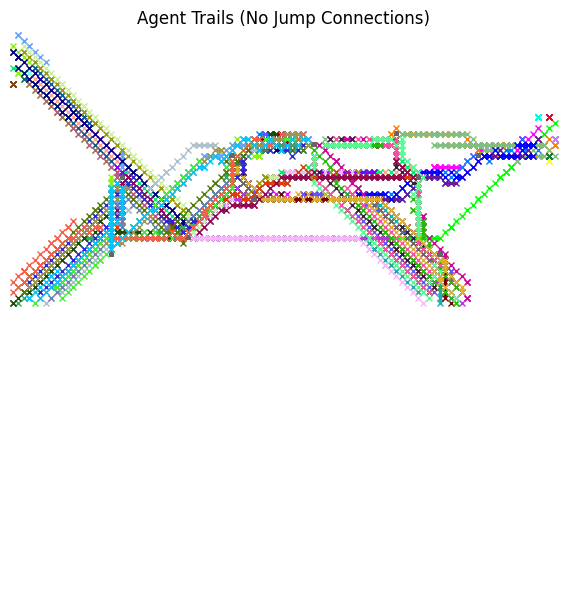

In [ ]:
visualize_agent_trails(results, 50)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, ListedColormap

def get_waypoint_proximity_coords(matrix, min_dist=1, max_dist=3):
    waypoint_positions = np.argwhere(matrix == -1)
    proximity_set = set()

    for wx, wy in waypoint_positions:
        for dx in range(-max_dist, max_dist + 1):
            for dy in range(-max_dist, max_dist + 1):
                if 0 < abs(dx) + abs(dy) <= max_dist:  # Manhattan distance
                    nx, ny = wx + dx, wy + dy
                    if 0 <= nx < matrix.shape[0] and 0 <= ny < matrix.shape[1]:
                        proximity_set.add((nx, ny))
    return proximity_set


def compute_holding_heatmap(matrices):
    heatmap = np.zeros_like(matrices[0], dtype=int)

    for t in range(len(matrices) - 1):
        mat_now = matrices[t]
        mat_next = matrices[t + 1]

        proximity_set = get_waypoint_proximity_coords(mat_now)
        vehicle_ids = np.unique(mat_now)
        vehicle_ids = vehicle_ids[vehicle_ids > 0]  # Skip 0 and -1

        for vid in vehicle_ids:
            pos_now = np.argwhere(mat_now == vid)
            pos_next = np.argwhere(mat_next == vid)

            if len(pos_now) == 0 or len(pos_next) == 0:
                continue  # vehicle not found in either frame

            p_now = tuple(pos_now[0])
            p_next = tuple(pos_next[0])

            if p_now == p_next and p_now in proximity_set:
                heatmap[p_now] += 1

    return heatmap


def plot_holding_heatmap(base_matrix, heatmap):
    fig, ax = plt.subplots(figsize=(6, 6))
    img = np.zeros((*base_matrix.shape, 3))  # RGB image

    max_holding = heatmap.max() if heatmap.max() > 0 else 1
    for i in range(base_matrix.shape[0]):
        for j in range(base_matrix.shape[1]):
            if base_matrix[i, j] == -1:
                img[i, j] = [1, 0, 0]  # Red for waypoint
            elif heatmap[i, j] > 0:

                val = heatmap[i, j] / max_holding
                img[i, j] = [val, val, val]  # Darker gray for more holds
                #print(val)
            else:
                img[i, j] = [0,1, 0]  # White for empty

    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Holding Pattern Plot")
    plt.show()




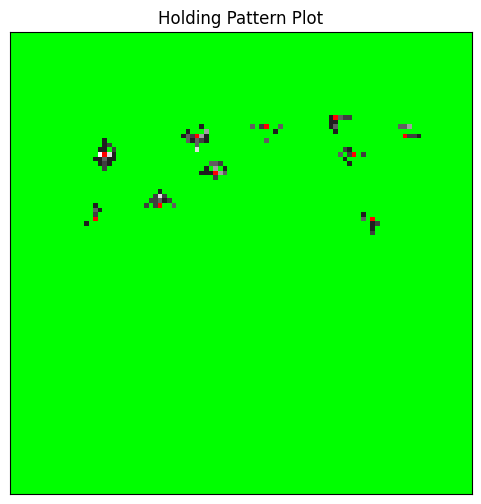

In [ ]:
heatmap = compute_holding_heatmap(results)
plot_holding_heatmap(results[0], heatmap)